In [2]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import sys
sys.path.append("../")
from tesorai_search import data_parsing_utils

### Preprocess Outputs

In [7]:
_PATH = "../data/benchmark_results/bassani_sternberg"

In [8]:
# Preprocess MQ 100% FDR results
psm_mq_fdr100 = pd.read_csv(
    f"{_PATH}/maxquant/msms_100pct.txt",
    usecols=[
        "Raw file",
        "Scan number",
        "Scan index",
        "Sequence",
        "Modified sequence",
        "Reverse",
        "PEP",
        "Score",
        "Precursor Intensity",
        "Fraction of total spectrum",
        "Base peak fraction",
    ],
    sep="\t",
)
psm_mq_fdr100["score"] = -psm_mq_fdr100.PEP
psm_mq_fdr100["is_decoy"] = psm_mq_fdr100["Reverse"].apply(lambda x: x == "+")
psm_mq_fdr100 = psm_mq_fdr100.loc[
    psm_mq_fdr100.groupby(["Scan number", "Raw file"])["score"].idxmax()
]
data_parsing_utils.compute_qs(psm_mq_fdr100)
psm_mq_fdr100["Sequence"] = psm_mq_fdr100["Sequence"].str.replace("I", "L")

AttributeError: module 'tesorai_search.data_parsing_utils' has no attribute 'compute_qs'

In [9]:
# Preprocess MSF 100% FDR results
psm_msf_fdr100 = pd.read_csv(
    f"{_PATH}/fragpipe/psms_100pct.txt",
    usecols=[
        "Raw file",
        "Scan number",
        "Sequence",
        "Modified sequence",
        "Reverse",
        "Score",
    ],
    sep="\t",
)
psm_msf_fdr100["score"] = psm_msf_fdr100["Score"]
psm_msf_fdr100["is_decoy"] = psm_msf_fdr100["Reverse"].apply(lambda x: x == "+")
psm_msf_fdr100 = psm_msf_fdr100.loc[
    psm_msf_fdr100.groupby(["Scan number", "Raw file"])["score"].idxmax()
]
data_parsing_utils.compute_qs(psm_msf_fdr100)
psm_msf_fdr100["Sequence"] = psm_msf_fdr100["Sequence"].str.replace("I", "L")

AttributeError: module 'tesorai_search.data_parsing_utils' has no attribute 'compute_qs'

In [5]:
# Preprocess Tesorai 100% FDR results
psm_ts_fdr100 = pd.read_csv(f"{_PATH}/tesorai/psms_100pct.txt", sep="\t")
psm_ts_fdr100["clean_sequence"] = psm_ts_fdr100["clean_sequence"].str.replace("I", "L")
# psm_ts_fdr100["scan_id"] = psm_ts_fdr100["scan_id"].astype(int)
psm_ts_fdr100 = psm_ts_fdr100.loc[
    psm_ts_fdr100.groupby(["filename", "scan_id"])["score"].idxmax()
]

In [6]:
# # Preprocess Tesorai 1% FDR results
psm_ts_fdr1 = pd.read_csv(f"{_PATH}/tesorai/psms_1pct.txt", sep="\t")
psm_ts_fdr1["clean_sequence"] = psm_ts_fdr1["clean_sequence"].str.replace("I", "L")
# psm_ts_fdr1["scan_id"] = psm_ts_fdr1["scan_id"].astype(int)
psm_ts_fdr1 = psm_ts_fdr1.loc[
    psm_ts_fdr1.groupby(["filename", "scan_id"])["score"].idxmax()
]

### MQ vs Tesorai

In [7]:
merged_mq = pd.merge(
    psm_mq_fdr100,
    psm_ts_fdr100,
    left_on=["Raw file", "Scan number"],
    right_on=["filename", "scan_id"],
    how="right",
    suffixes=["_fdr100", ""],
)


def get_class(x):
    if x.is_decoy:
        return "decoy"
    # Note: "qs" correspond to MQ q-values
    if x.qs <= 0.01:
        return "MQ (1% FDR)"

    if x.qs <= 0.05:
        return "MQ (5% FDR)"

    if x.qs <= 1:
        return "MQ (>5% FDR)"
    return "Not found by MQ"


merged_mq["class"] = merged_mq.apply(get_class, axis=1)
merged_mq["Tesorai score"] = merged_mq.score
merged_mq["Andromeda score"] = merged_mq.Score

In [8]:
def format_plots(text):
    plt.rcParams["axes.labelsize"] = 15

    plt.legend(fontsize="large", title_fontsize="large", title="Decoy", markerscale=5)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    # Add panel letter at the top left corner
    plt.text(
        -0.1,
        1.1,
        text,
        transform=plt.gca().transAxes,
        fontsize=15,
        fontweight="bold",
        va="top",
        ha="right",
    )

<Figure size 400x400 with 0 Axes>

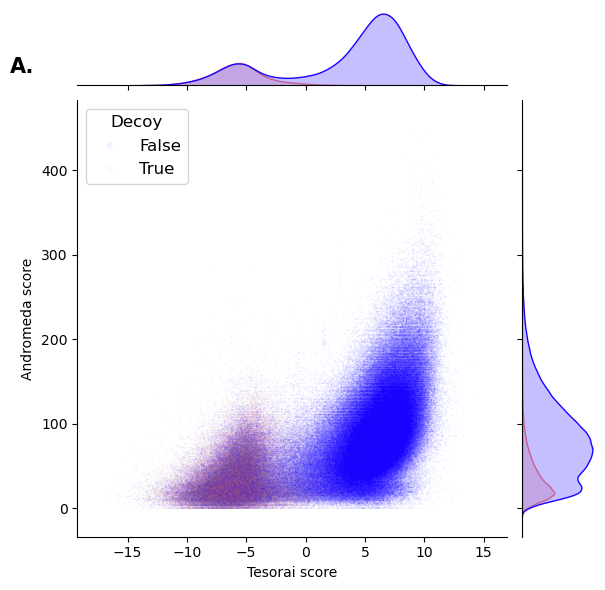

In [9]:
# merged_mq_plot = merged_mq.dropna(subset=['Tesorai score', 'Andromeda score'])
plt.figure(figsize=(4, 4))
sns.jointplot(
    data=merged_mq,
    x="Tesorai score",
    y="Andromeda score",
    hue="is_decoy",
    kind="scatter",
    alpha=0.05,
    s=1,
    palette=["#1902ff", "salmon"],
)

format_plots("A.")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 400x400 with 0 Axes>

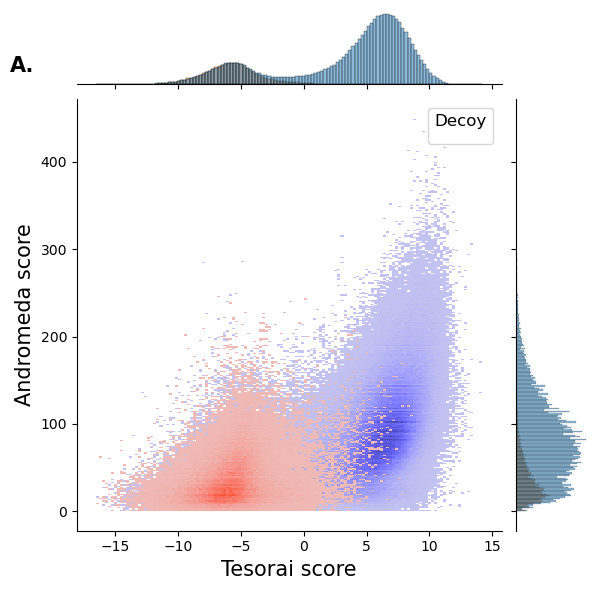

In [10]:
plt.figure(figsize=(4, 4))
sns.jointplot(
    data=merged_mq,
    x="Tesorai score",
    y="Andromeda score",
    hue="is_decoy",
    kind="hist",
    alpha=1,
    palette=["#1902ff", "salmon"],
)
format_plots("A.")

### MSF vs Tesorai

In [11]:
merged = pd.merge(
    psm_msf_fdr100,
    psm_ts_fdr100,
    left_on=["Raw file", "Scan number"],
    right_on=["filename", "scan_id"],
    how="right",
    suffixes=["_fdr100", ""],
)


def get_class(x):
    if x.is_decoy:
        return "decoy"
    if x.qs <= 0.01:
        return "MSF (1% FDR)"

    if x.qs <= 0.05:
        return "MSF (5% FDR)"

    if x.qs <= 1:
        return "MSF (>5% FDR)"

    return "Not found by MSF"


merged["class"] = merged.apply(get_class, axis=1)
merged["Tesorai score"] = merged.score
merged["MSFragger Hyperscore"] = merged.Score

<Figure size 400x400 with 0 Axes>

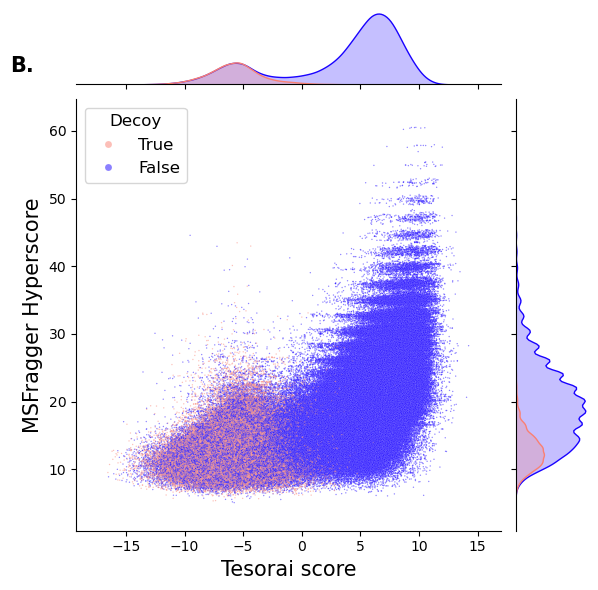

In [12]:
plt.figure(figsize=(4, 4))
sns.jointplot(
    data=merged,
    x="Tesorai score",
    y="MSFragger Hyperscore",
    hue="is_decoy",
    kind="scatter",
    alpha=0.5,
    hue_order=[True, False],
    s=1,
    palette=["salmon", "#1902ff"],
)
format_plots("B.")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 400x400 with 0 Axes>

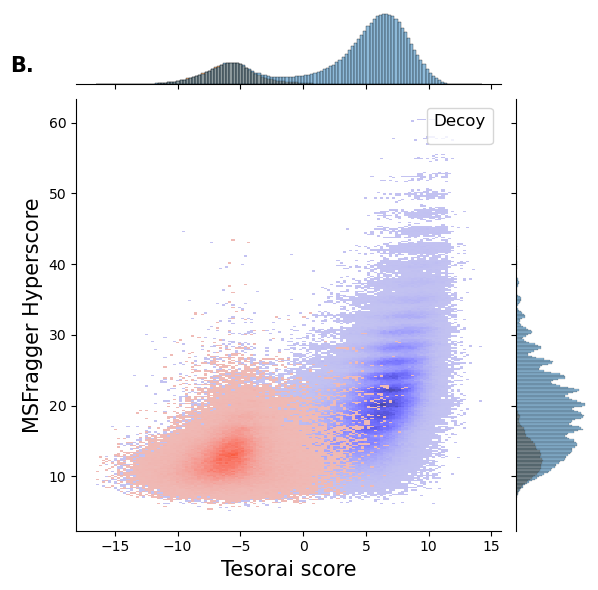

In [13]:
plt.figure(figsize=(4, 4))
sns.jointplot(
    data=merged,
    x="Tesorai score",
    y="MSFragger Hyperscore",
    hue="is_decoy",
    kind="hist",
    alpha=1,
    palette=["#1902ff", "salmon"],
)
format_plots("B.")

In [14]:
from matplotlib.lines import Line2D


def make_legend_elements(color_label_pairs, cutoff_label="TS 1% FDR cutoff"):
    legend_kwargs = {"lw": 0, "marker": "s", "markersize": 10}
    elements = [
        Line2D([0], [0], color=color, label=label, **legend_kwargs)
        for color, label in color_label_pairs
    ]
    elements.append(Line2D([0], [0], color="black", linestyle="--", label=cutoff_label))
    return elements

Text(-0.1, 1.1, 'D.')

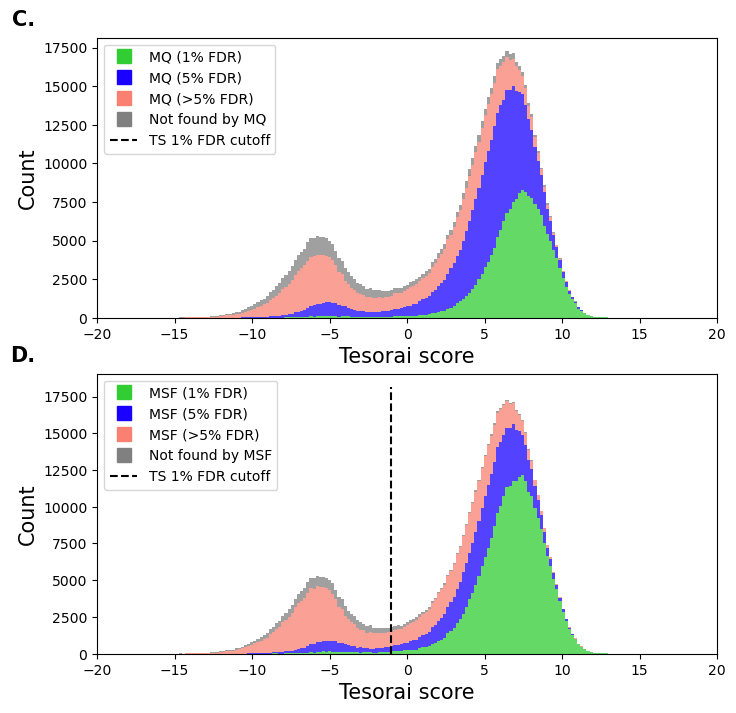

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

sns.histplot(
    merged_mq.query("~is_decoy"),
    x="Tesorai score",
    hue="class",
    bins=np.linspace(-30, 20, 250),
    multiple="stack",
    hue_order=["Not found by MQ", "MQ (>5% FDR)", "MQ (5% FDR)", "MQ (1% FDR)"],
    palette=["grey", "salmon", "#1902ff", "limegreen"],
    edgecolor=None,
    ax=axs[0],
)
cutoff = psm_ts_fdr1.score.min()
max_height = plt.gca().get_ylim()[1]
axs[0].vlines(
    cutoff, 0, max_height, color="black", linestyle="--", label="1% FDR cutoff"
)
axs[0].set_xlim(left=-20, right=20)

color_label_pairs_c = [
    ("limegreen", "MQ (1% FDR)"),
    ("#1902ff", "MQ (5% FDR)"),
    ("salmon", "MQ (>5% FDR)"),
    ("grey", "Not found by MQ"),
]
legend_elements_c = make_legend_elements(color_label_pairs_c)
axs[0].legend(handles=legend_elements_c, title="", loc="upper left")

axs[0].text(
    -0.1,
    1.1,
    "C.",
    transform=axs[0].transAxes,
    fontsize=15,
    fontweight="bold",
    va="top",
    ha="right",
)


sns.histplot(
    merged.query("~is_decoy"),
    x="Tesorai score",
    hue="class",
    bins=np.linspace(-30, 20, 250),
    multiple="stack",
    hue_order=["Not found by MSF", "MSF (>5% FDR)", "MSF (5% FDR)", "MSF (1% FDR)"],
    palette=["grey", "salmon", "#1902ff", "limegreen"],
    edgecolor=None,
    ax=axs[1],
)
cutoff = psm_ts_fdr1.score.min()
max_height = plt.gca().get_ylim()[1]
axs[1].vlines(
    cutoff, 0, max_height, color="black", linestyle="--", label="1% FDR cutoff"
)
axs[1].set_xlim(left=-20, right=20)


color_label_pairs_d = [
    ("limegreen", "MSF (1% FDR)"),
    ("#1902ff", "MSF (5% FDR)"),
    ("salmon", "MSF (>5% FDR)"),
    ("grey", "Not found by MSF"),
]
legend_elements_d = make_legend_elements(color_label_pairs_d)
axs[1].legend(handles=legend_elements_d, title="", loc="upper left")

axs[1].text(
    -0.1,
    1.1,
    "D.",
    transform=plt.gca().transAxes,
    fontsize=15,
    fontweight="bold",
    va="top",
    ha="right",
)

In [16]:
merged = pd.merge(
    psm_msf_fdr100,
    psm_ts_fdr100,
    left_on=["Raw file", "Scan number"],
    right_on=["filename", "scan_id"],
    how="right",
    suffixes=["_fdr100", ""],
)


def get_class(x):
    if x.is_decoy:
        return "decoy"
    # Note: only MQ results have "qs" as we use rescoring.lance here for TS
    if x.qs <= 0.01:
        return "MSF (1% FDR)"

    if x.qs <= 0.05:
        return "MSF (5% FDR)"

    if x.qs <= 0.1:
        return "MSF (10% FDR)"

    return "MSF (>10% FDR)"


merged["class"] = merged.apply(get_class, axis=1)
merged["Tesorai score"] = merged.score
merged["MSFragger Hyperscore"] = merged.Score